<ipython-input-1-8d1ab1de9c97>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9561828874675149' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self.item_similarity_df.loc[i, j] = numerator / denominator if denominator != 0 else 0
<ipython-input-1-8d1ab1de9c97>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9525793444156805' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self.item_similarity_df.loc[i, j] = numerator / denominator if denominator != 0 else 0
<ipython-input-1-8d1ab1de9c97>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9594032236002469' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  s

Training complete. Item-item similarity matrix built.


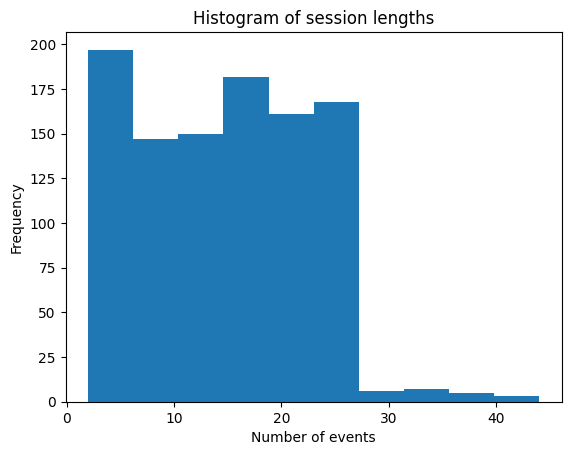

Number of sessions: 1026
Average events per session: 14.688109161793372
Category with highest bounce rate: 18
Country with highest average visit count: Japan
Performer with most visits by category: dance
Session item IDs (converted): [1, 2, 3, 4]
Processing session item: 1
Similar items for session item 1:
item_id
0      0.956183
2      1.000000
3      0.973729
4      0.962250
5      1.000000
         ...   
195    1.000000
196    0.959403
197    0.966988
198    0.968963
199    0.772460
Name: 1, Length: 199, dtype: float64
Processing session item: 2
Similar items for session item 2:
item_id
0      0.952579
1      1.000000
3      0.907841
4      0.864242
5      0.890871
         ...   
195    0.948683
196    0.943456
197    0.871780
198    0.964764
199    0.966988
Name: 2, Length: 199, dtype: float64
Processing session item: 3
Similar items for session item 3:
item_id
0      0.959403
1      0.973729
2      0.907841
4      0.921681
5      0.898645
         ...   
195    0.946729
196    0

In [1]:
#for this code, item based collaborative filtering is done where filtering searches for items (nearest neighbors – NN)
#here similarity is calculated using Cosine Similarity


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

class Recommender:
    def __init__(self, items_path, users_path, events_path):
        #Load data
        self.items = pd.read_csv(items_path)
        self.users = pd.read_csv(users_path)
        self.events = pd.read_csv(events_path)
        self.events['timestamp'] = pd.to_datetime(self.events['timestamp'], unit='s')  # Convert timestamp from Unix time
        self.events = self.events.sort_values(by=['user_id', 'timestamp'])



    #in train here cosine similarity fomula is used to calculate the similarity of the items with the ones in ongoing session
    def train(self):
      # created a user-item matrix (ratings-like interaction matrix)
      user_item_matrix = self.events.pivot_table(index='user_id', columns='item_id', aggfunc='size', fill_value=0)

      # computed item-item similarity using cosine similarity
      self.item_similarity_df = pd.DataFrame(index=user_item_matrix.columns, columns=user_item_matrix.columns, dtype=np.float32)

      for i in self.item_similarity_df.columns:
          for j in self.item_similarity_df.columns:
              if i == j:
                  continue
              # Get the users who rated/interacted with both items i and j
              common_users = user_item_matrix[(user_item_matrix[i] > 0) & (user_item_matrix[j] > 0)].index

              if len(common_users) == 0:
                  self.item_similarity_df.loc[i, j] = 0
                  continue

              # Applied cosine similarity formula for items i and j
              ratings_i = user_item_matrix.loc[common_users, i]
              ratings_j = user_item_matrix.loc[common_users, j]

              # The numerator: sum of the product of corresponding ratings
              numerator = np.sum(ratings_i * ratings_j)

              # The denominator: product of the Euclidean norms (magnitude) of the rating vectors
              denominator = np.sqrt(np.sum(ratings_i ** 2)) * np.sqrt(np.sum(ratings_j ** 2))

              # Calculated the similarity (cosine of the angle between the vectors)
              self.item_similarity_df.loc[i, j] = numerator / denominator if denominator != 0 else 0

      print("Training complete. Item-item similarity matrix built.")




    # in the below section analysis is done based on the problem in read_me file
    def analyse(self):
        # Step 1: Separate sessions by a gap of >= 8 hours between two events for each user
        self.events['session_gap'] = self.events.groupby('user_id')['timestamp'].diff().dt.total_seconds() >= 8 * 3600
        self.events['session_id'] = self.events.groupby('user_id')['session_gap'].cumsum()
        self.events.drop('session_gap', axis=1, inplace=True)

        # Step 2: Remove duplicate visits of the same item within each session
        self.events = self.events.drop_duplicates(subset=['user_id', 'session_id', 'item_id'])

        # Step 3: Filter out sessions with only a single event
        session_sizes = self.events.groupby(['user_id', 'session_id']).size()
        valid_sessions = session_sizes[session_sizes > 1].index
        self.events = self.events[self.events.set_index(['user_id', 'session_id']).index.isin(valid_sessions)].reset_index(drop=True)

        # Step 4: Calculate statistics
        num_sessions = len(valid_sessions)
        avg_events_per_session = session_sizes[session_sizes > 1].mean()

        # Step 5: Histogram of session lengths for valid sessions (with > 1 event)
        valid_session_sizes = session_sizes[session_sizes > 1]
        plt.hist(valid_session_sizes, bins=10)
        plt.xlabel("Number of events")
        plt.ylabel("Frequency")
        plt.title("Histogram of session lengths")
        plt.show()

        # Step 6: Category with the highest bounce rate (last event in each session)
        last_events = self.events.groupby('session_id').last()
        highest_bounce_category = last_events['item_id'].value_counts().idxmax()

        # Step 7: Country with the highest average visit count per user
        user_country_visits = self.events.groupby('user_id').size().groupby(self.users.set_index('user_id')['country']).mean()
        highest_avg_visit_country = user_country_visits.idxmax()

        # Step 8: Performer with most visits by category (assuming "category" refers to item types in `items`)
        most_visited_performers = self.items.groupby('category')['item_id'].count().idxmax()

        # Output results
        print(f"Number of sessions: {num_sessions}")
        print(f"Average events per session: {avg_events_per_session}")
        print(f"Category with highest bounce rate: {highest_bounce_category}")
        print(f"Country with highest average visit count: {highest_avg_visit_country}")
        print(f"Performer with most visits by category: {most_visited_performers}")




    #Recommend items based on the session's item history using cosine similarity directly
    def recommend(self, session_item_ids):
      total_similarities = pd.Series(dtype=float)
      session_item_ids = [int(item) for item in session_item_ids if item.strip().isdigit()]
      print(f"Session item IDs (converted): {session_item_ids}")

      # Checked similarity for each item in the session
      for session_item in session_item_ids:
          if session_item in self.item_similarity_df.index:
              print(f"Processing session item: {session_item}")
              # Get the items similar to session_item, excluding the session_item itself
              similar_items = self.item_similarity_df.loc[session_item].drop(session_item)
              print(f"Similar items for session item {session_item}:\n{similar_items}")

              # Combined the similar items for all session items
              total_similarities = pd.concat([total_similarities, similar_items])

      # Sorted the combined list of similar items by similarity score (descending)
      total_similarities = total_similarities.sort_values(ascending=False)

      # Droped any items that were part of the session (we don't want to recommend them)
      total_similarities = total_similarities[~total_similarities.index.isin(session_item_ids)]

      # Get the 5 unique items based on similarity
      recommended_items = total_similarities.index.unique()[:5]
      print(f"\nFinal recommended items for session {session_item_ids}: {recommended_items}")
      return recommended_items






items_path = './items.csv'
users_path = './users.csv'
events_path = './events.csv'
session_path = './sessions.csv'

# Initialize the Recommender
r = Recommender(items_path, users_path, events_path)

# Train the model
r.train()

# Analyze the dataset
r.analyse()

# Evaluate recommender
with open(session_path, 'r') as f:
    hits = 0
    total = 0
    for row in f.readlines():
        parts = row.split("\t")
        session = parts[0].split(",")
        target_item = row[1]
        recommended = r.recommend(session)
        if target_item in recommended:
            hits +=1
        total+=1
    print("Hits: {}/{}".format(hits, total))
